In [ ]:
### 4C16 Lab 6 - Self Driving Car

In [ ]:
### First!  Read https://github.com/frcs/EE4C16-self-driving-lab for more info.

### Second!  Read this carefully!

# In this lab you will train a neural net to drive a virtual driving simulator,
# using data recorded from your own manual operation of the sim.
#
# Your model will attempt to predict the correct steering angle, given the input
# images, using your recorded laps as training data.
#
# Your model will be operating in cruise control mode; it does not have any throttle
# input, and will not be able to reverse.
#
# Step 1 is to run the simulator on your local machine (within Windows, in the CADLab)
# and drive around while recording training data.  For each timestep in your driving,
# three images are recorded: the center (straight ahead) view, and also left and right 
# views.  Your steering angle is also recorded.
#
# Step 2: You will upload the training data to your cloud instance and train there, to 
# take advantage of the GPU.
#
# Step 3: You will download the model and use it to pilot the car around the track ('autonomous mode')
#
# Step 4: You will upload the record of the car's positions back to your instance using Jupyter
#
# Step 5: You will 'git add' the record of the car's positions, and 'submit-lab 6' to check your score.
#
# You can repeat steps 2--5 with more training, more complex models, etc.
# You can also repeat step 1 if you decide you need more or more varied training data.

In [1]:
# Import some necessary modules.
import keras
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, Dropout, Activation
from keras.regularizers import l2
from keras.models import save_model

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import random
import ntpath
import csv
import PIL


Using TensorFlow backend.


In [2]:
# Define some callbacks to plot progress of training.
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

In [3]:
def import_csv_data(logfile):
    with open(logfile, 'r') as f:
        data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

    # Each row of the CSV contains the data from one timestep of the training recording.
    # Column semantics are as follows:
    center = 0   # Path (or filename) of image file containing center view
    left = 1     # Image file containing left view
    right = 2    # Image file containing right view
    angle = 3    # Desired orientation of car (steering angle)
    accel = 4    # Acceleration (throttle)
    stop = 5     # Not sure what this..
    speed = 6    # Speed

    # Condense the recorded data into a map of image files (input) to steering angle (output).
    # Note that in the simulation, when our NN-model is driving, it will be provided the 
    # only front image as input.
    parsed_data = dict()

    for row in data:  # 'row' is an array with values corresponding to columns in the CSV.
        # Skip examples with a quasi-static car.
        if float(row[speed]) < 0.01:
            continue  
        
        center_image = './IMG/' + ntpath.basename(row[center])
        left_image = './IMG/' + ntpath.basename(row[left])
        right_image = './IMG/' + ntpath.basename(row[right])
        
        parsed_data[center_image] = float(row[angle])
        
        # This is a trick to maximize the data available.  Have a think about what is going on here...
        parsed_data[left_image] = float(row[angle]) + 0.20
        parsed_data[right_image] = float(row[angle]) - 0.20

    return parsed_data

In [ ]:
# You should have generated some training data on your local workstation at this point, and the instructions
# on how to zip them (https://github.com/frcs/EE4C16-self-driving-lab)

# Run this cell to extract the uploaded training data:
!rm -rf IMG
!unzip -o -qq recordings.zip
driving_log = './driving_log.csv'
training_data = import_csv_data(driving_log)

('./IMG/center_2019_11_07_16_00_33_512.jpg', 0.0)


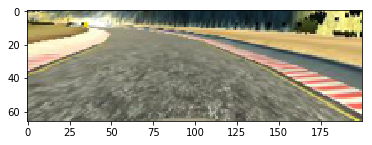

In [ ]:
def load_image(path_to_jpg):
    im = PIL.Image.open(path_to_jpg)
    im_width = im.size[0]
    im_height = im.size[1]
    
    # We are going to discard the sky and the car, to focus training on the road.
    # This crop isolates that portion.  You can see the effects by changing the values
    # and re-evaluating that cell, but they must match the original values (top=50, bottom=140)
    # when you train so as to match the input supplied from the simulator.
    left = 0
    right = im_width
    top = 50 # 0
    bottom = 140 # im_height
    
    im = im.crop((left, top, right, bottom))
    
    # We can shrink the image a bit to reduce training time.
    im = im.resize((200, 66), PIL.Image.BICUBIC)
    im = np.asarray(im)
    return im

A = next(iter(training_data.items()))
print(A)
im = load_image(A[0])
plt.imshow(im)


In [ ]:
def data_generator(training_data, batch_size, reject_above=True, reject_thresh=0.0):
    inputs_batch = []
    targets_batch = []
    
    while True:
        random.seed(42)
        for idx, (k, v) in enumerate(training_data.items()):
            sample = random.random()
            reject_item = ((sample > reject_thresh and reject_above) or
                        (sample <= reject_thresh and not reject_above))
            
            if not reject_item:
                decoded_image = load_image(k)
                # Important--as we've stressed before--to scale the input data to -1..1.
                decoded_image = 2.0*decoded_image/255 - 1
                label = v

                inputs_batch.append(decoded_image)
                targets_batch.append(label)

            if (len(inputs_batch)+1) % batch_size == 0:
                yield (np.asarray(inputs_batch), np.asarray(targets_batch))
                inputs_batch.clear()
                targets_batch.clear()


In [ ]:
# Define your model in this cell.
# See the paper 'End to End Learning for Self-Driving Cars' (Bojarski et al) for some ideas.

inputs = Input(shape=(66, 200, 3))

x = inputs

## Add your layers here.  Go nuts!
## (DO NOT ADD A LAMBDA LAYER to scale the input -- which you might see used in other online examples
##   -- we do our scaling of input data in the data_generator, above).

x = Conv2D(24, [5,5], activation='elu', padding='valid', strides=(2, 2)) (x)
x = Dropout(0.2)(x)
x = Conv2D(36, [5,5], activation='elu', padding='valid', strides=(2, 2)) (x)
x = Dropout(0.2)(x)
x = Conv2D(48, [5,5], activation='elu', padding='valid', strides=(2, 2)) (x)
x = Dropout(0.2)(x)
x = Conv2D(64, [3,3], activation='elu', padding='valid') (x)
x = Dropout(0.2)(x)
x = Conv2D(64, [3,3], activation='elu', padding='valid') (x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(100)(x)
x = Dropout(0.5)(x)
x = Dense(50)(x)
x = Dropout(0.5)(x)
x = Dense(10)(x)
x = Dropout(0.5)(x)

## Your output is a single float: the desired steering angle.
output = Dense(1)(x)

model = keras.models.Model(inputs=inputs, outputs=output)
model.summary()
model.compile(optimizer='adam', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 22, 48)         0         
__________

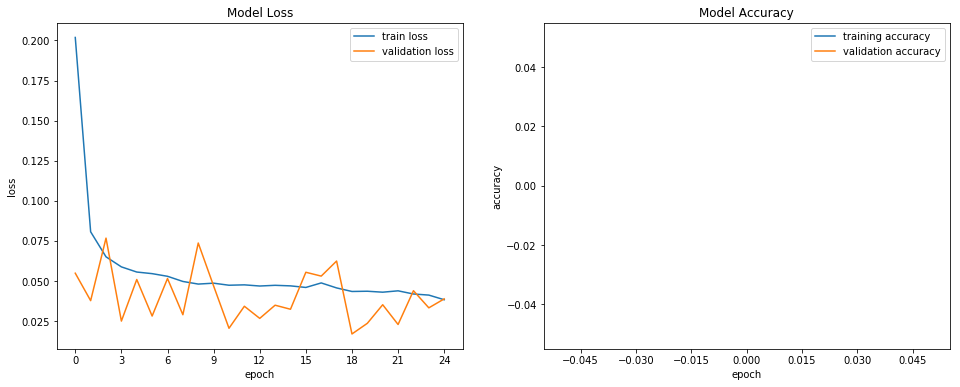

In [ ]:
# Training.  Re-evaluate this cell repeatedly to train more.
batch_size = 512
validation_fraction = 0.1  # Probably best to leave this value alone...
model.fit_generator(
    generator=data_generator(training_data, batch_size, reject_above=False, reject_thresh=validation_fraction),
    validation_data=data_generator(training_data, batch_size=64, reject_above=True, reject_thresh=validation_fraction),
    steps_per_epoch=(1-validation_fraction)*len(training_data)//batch_size,
    validation_steps=validation_fraction*len(training_data)//batch_size,
    epochs=25,
    verbose=1,
    callbacks=[PlotLossAccuracy()],
    shuffle=True
)

In [ ]:
# Save the model to disk (when done training).
save_model(model, './model.h5')

In [ ]:
# Now: 
# * download your model using the Jupyter interface
# * run the simulator in autonomous mode
# * kick off your robot driver (python drive.py model.h5)
# * wait for the car to crash, or head happily into the sunset, or whatever
# * close or quit the simulator
# * terminate your robot driver (ctrl-c in the console window)
# * upload the file 'car_positions.npz' from your workstation to the lab-06 dir on your instance (using Jupyter)
# * add this file to your repo: git add lab-06/car_positions.npz (in your remote terminal)
# * commit this addition: git commit -m 'added car positions'
# * 'git push'
# * 'submit-lab 6'